# Пример использования KNNImputer для замены пропусков



Документация - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html  

Пример - https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29

**Подключение библиотек и скриптов**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', 50)

### Загрузка датасета

In [3]:
TRAIN_DATASET_PATH = '../../Kurs_project_task/train.csv'
TEST_DATASET_PATH = '../../Kurs_project_task/test.csv'

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0000,47.9816,29.4428,6.0000,7,9.0000,1969,0.0890,B,B,33,7976,5,nan,0,11,B,"184,966.9307"
15053,41,3.0000,65.6836,40.0495,8.0000,7,9.0000,1978,0.0001,B,B,46,10309,1,240.0000,1,16,B,"300,009.4501"
4765,53,2.0000,44.9480,29.1976,0.0000,8,12.0000,1968,0.0496,B,B,34,7759,0,229.0000,1,3,B,"220,925.9085"
5809,58,2.0000,53.3530,52.7315,9.0000,8,17.0000,1977,0.4379,B,B,23,5735,3,"1,084.0000",0,5,B,"175,616.2272"
10783,99,1.0000,39.6492,23.7762,7.0000,11,12.0000,1976,0.0123,B,B,35,5776,1,"2,078.0000",2,4,B,"150,226.5316"


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train.shape

(10000, 19)

### Приведение типов

In [6]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train[feature_bin_names] = train[feature_bin_names].replace({'A':0, 'B':1})

### Обработка пропусков

In [7]:
train.isna().sum()[train.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

**Базовый вариант** - обучим модель на данных без признаков с пропусками. Для предсказания используем GradientBoostingRegressor.

In [8]:
feature_names = train.drop(['LifeSquare', 'Healthcare_1', 'DistrictId', 'Price'], axis=1).columns
target_name = ['Price']

X = train[feature_names]
y = train[target_name]

In [9]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    n_iter_no_change=10,
    max_depth=8,
    max_features=6,
    random_state=42)

In [10]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(gb_model, X, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores.mean()) # R2: 0.7436

R2: 0.7436


**1 вариант** - используем KNNImputer по умолчанию

In [11]:
feature_names = train.drop(['DistrictId', 'Price'], axis=1).columns
X = train[feature_names]
X.isna().sum()[X.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [12]:
imputer = KNNImputer()

X_imp = imputer.fit_transform(X)
scores = cross_val_score(gb_model, X_imp, y, scoring='r2', cv=cv)
print('R2: %.4f' % scores.mean()) # R2: 0.7483

R2: 0.7483


Метрика немного выросла.

**2 вариант** - посмотрим, как влияет параметр n_neighbors (количество соседей) на качество предсказания

In [13]:
results = list()
for n in range(3, 21):
    imputer = KNNImputer(n_neighbors=n)
    X_imp = imputer.fit_transform(X)
    scores = cross_val_score(gb_model, X_imp, y, scoring='r2', cv=cv)
    results.append(scores)
    #print('R2 train: %.4f - n_neighbors=%d' % (scores.mean(), n))

res = pd.DataFrame(results, index=list(range(3, 21)))
res = res.T.stack().reset_index(1)
res.columns = ['n_neighbors', 'score']

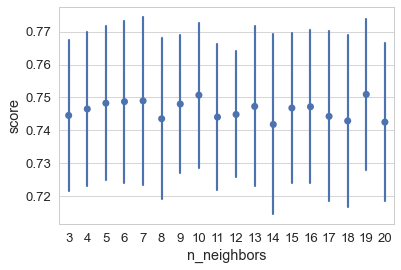

In [14]:
sns.pointplot(x='n_neighbors', y='score', data=res, join=False, estimator=np.mean, ci='sd');

In [15]:
res.groupby('n_neighbors')['score'].agg(
    mean='mean', std='std', max='max', min='min').sort_values('mean', ascending=False)

,mean,std,max,min
n_neighbors,,,,
19,0.7509,0.0242,0.8038,0.7192
10,0.7507,0.0232,0.8004,0.7196
7,0.7490,0.0269,0.8090,0.7134
6,0.7487,0.0259,0.7996,0.6965
5,0.7483,0.0246,0.8030,0.7106
9,0.7480,0.0220,0.7976,0.7208
13,0.7473,0.0257,0.7996,0.7062
16,0.7472,0.0246,0.8046,0.7115
15,0.7468,0.0241,0.7937,0.7071


Максимальное значение метрики дает n_neighbors=19. Среднее R2 в этом случае равно 0.7509.

**3 вариант** - подберем по сетке параметр n_neighbors в случае работы с отложенной выборкой

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7500, 17), (2500, 17), (7500, 1), (2500, 1))

In [17]:
X_train.isna().sum()[X_train.isna().sum() != 0]

LifeSquare      1594
Healthcare_1    3614
dtype: int64

In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline(steps=[('imputer', KNNImputer()), 
                           ('model', gb_model)])

params = {
    'imputer__n_neighbors' : np.arange(3, 21)
}

grid = GridSearchCV(pipeline, params, cv=cv, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print('R2 train: %.4f' % grid.best_score_)
print('R2 valid: %.4f' % grid.score(X_valid, y_valid))
print(grid.best_params_)

R2 train: 0.7334
R2 valid: 0.7280
{'imputer__n_neighbors': 9}


Таким образом, следующий пайплайн можно использовать для замены пропусков и предсказания цен на квартиры. 

In [24]:
pipeline = Pipeline(steps=[('scaler', RobustScaler()),
                           ('imputer', KNNImputer(n_neighbors=9)), 
                           ('model', gb_model)])
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_valid)
print('R2: %.4f' % r2_score(y_valid, y_hat)) # R2: 0.7351 (9)

R2: 0.7351


Что еще можно проверить?

- попробовать заполнить пропуски только в одном признаке.
- использовать другой способ масштабирования.
- сравнить KNNImputer с другими способами замены пропусков.